# Import et export de la clé d'API dans une variable d'environnement

In [1]:
import os
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langchain_groq import ChatGroq
from datetime import datetime
from langchain.schema import SystemMessage, AIMessage, HumanMessage

In [ ]:
GROQ_API_KEY = "Ajoutez votre clé API Groq ici"
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

# Création du state

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    next_node: str 


graph_builder = StateGraph(State)

In [4]:
llm = ChatGroq(
    model_name="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0.7,
)

# Création des tools du router

In [5]:
selector_llm = ChatGroq(
    model_name="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0,
)

In [6]:
def get_date(state:State):
    return {
        "messages": state["messages"] + [
            SystemMessage(content=f"date : {datetime.now()}")
        ],
        "next_node": "chatbot",
    }

In [7]:
def chatbot(state: State):
    return {
        "messages": state["messages"] + [llm.invoke(state["messages"])],
        "next_node": "chatbot"
        }

tools = [
    get_date,
]

In [8]:
def select_tool(state: State):
    """Choisit l'outil à appeler et mémorise le choix."""
    resp = selector_llm.invoke(f"""
You are **ToolSelector**, an inner agent whose only task is to decide which tool the outer agent must call next.
You NEVER answer the end-user directly.

You can use the following messages to decide which tool to call next:
[{state["messages"]}]
Remember that your answer must be one of the following: {', '.join(tool.__name__ for tool in tools)} or "chatbot". The response must be a signle word.
example 1 : chatbot
example 2 : get_date

                               """
                               )
    print("Selector response:", resp)
    if resp.content in [tool.__name__ for tool in tools]:
        choice = resp.content
    else:
        choice = "chatbot"
    print(choice)
    return {
        "messages": state["messages"],
        "next_node": choice,
    }

# Création des noeuds et des arrêtes

In [9]:
graph_builder.add_node("selector", select_tool)
graph_builder.add_node("chatbot", chatbot)

for node_fn in tools:
    graph_builder.add_node(node_fn.__name__, node_fn)

graph_builder.add_edge(START, "selector")

selections_possibles = {node_fn.__name__:node_fn.__name__ for node_fn in tools}
selections_possibles["chatbot"] = "chatbot"

graph_builder.add_conditional_edges(
    "selector",
    lambda state: state["next_node"],
    selections_possibles,
)
# Après chaque tool, on repasse par chatbot puis END
for tool in (tool.__name__ for tool in tools):
    graph_builder.add_edge(tool, "chatbot")

graph_builder.add_edge("chatbot", END)

In [10]:
graph = graph_builder.compile()

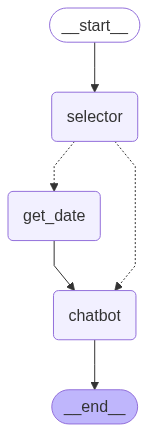

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            if not isinstance(value["messages"][-1],SystemMessage):
                print("Assistant:", value["messages"][-1].content)


stream_graph_updates("Quel jour sommes nous ?")

Selector response: content='get_date' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 136, 'total_tokens': 139, 'completion_time': 0.006218398, 'prompt_time': 0.005909071, 'queue_time': 0.105627211, 'total_time': 0.012127469}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'stop', 'logprobs': None} id='run--45d35c30-3b54-429c-8993-dd911c7e059f-0' usage_metadata={'input_tokens': 136, 'output_tokens': 3, 'total_tokens': 139}
get_date
Assistant: Quel jour sommes nous ?
Assistant: Nous sommes le jeudi 10 juillet 2025.
